In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

In [3]:
clusters = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters[clusters["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]
clusters

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [4]:
wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


In [5]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)
geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


In [6]:
binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

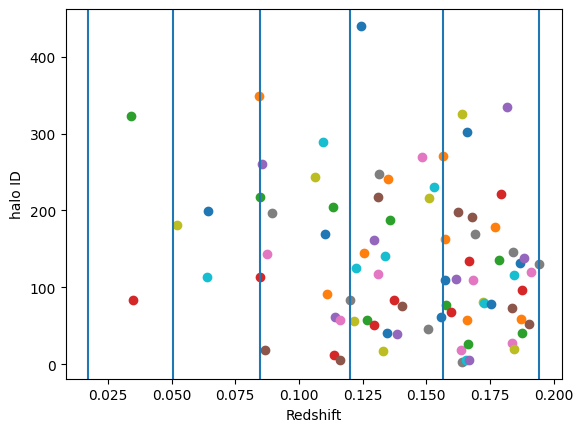

In [7]:
for cl_num in clusters.index[:]:
    #print(i, cl_num, clusters["z_true"][cl_num])
    plt.scatter(clusters["z_true"][cl_num], clusters["ihal"][cl_num])
    
for j in geometry["z_end"]:
    plt.axvline(j)
    
plt.xlabel("Redshift")
plt.ylabel("halo ID")
plt.show()

## (A) Single cluster: image and spectra

See https://cxc.cfa.harvard.edu/ciao/ahelp/dmstat.html for centroid searching method.

/home/aleksei/work/clusters/magneticum/utils/scripts.py:506: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1', '10', '100'])
/home/aleksei/work/clusters/magneticum/utils/scripts.py:510: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(['0', '1'])


<Figure size 640x480 with 0 Axes>

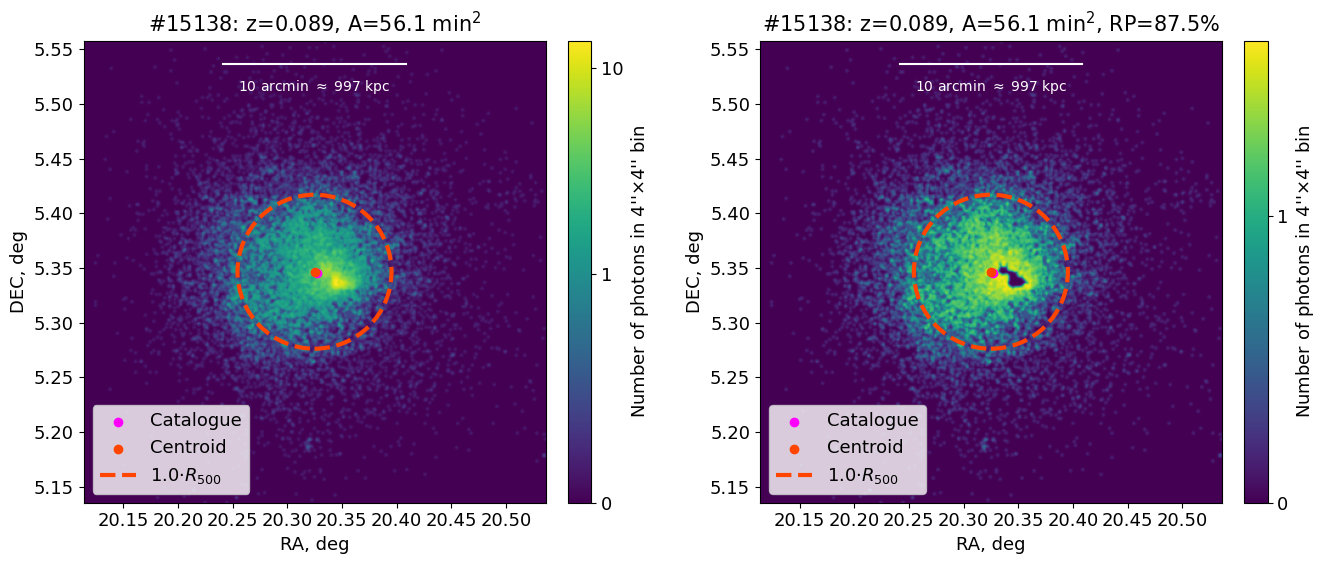

In [8]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(16,6))

cl_num = 15138 #6496
RRR = 1.0

plt.subplot(121)
pho_list = extract_photons_from_cluster(cl_num, r = RRR, centroid=True, 
                                        delete_bright_regions=False, draw=True,
                                        draw_additional=False)

plt.subplot(122)
pho_list = extract_photons_from_cluster(cl_num, r = RRR, centroid=True, 
                                        delete_bright_regions=True, draw=True,
                                        draw_additional=False)

#display(pho_list)

#plt.savefig('figures/cl_ex_2.pdf', format='pdf')#, bbox_inches='tight')

plt.show()

In [16]:
#plt.hist2d(pho_list["RA"], pho_list["DEC"],
#           bins=int(2*0.05*3600/4),
#           norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
#plt.gca().set_aspect('equal', 'box')
#plt.show()

#### How many photons are lost because of filtering?

In [45]:
#rates_unfiltered = []
rates_filtered = []

for ci in tqdm(clusters.index[:]):
    
    create_spectrum_and_fit_it(ci, 
                               borders=[0.4, 7.0], 
                               BACKGROUND=False, 
                               inside_radius=1.0,
                               #dbr=False)
                               dbr=True)
    adr = x.AllData(1).rate
    
    rates_unfiltered.append(adr[0])
    rates_filtered.append(adr[0])
    
#print(rates_unfiltered)

  0%|          | 0/84 [00:00<?, ?it/s]

In [9]:
zxs = [clusters.loc[i]["z_true"] for i in clusters.index]
normzxs = matplotlib.colors.Normalize(vmin=min(zxs), vmax=max(zxs), clip=True)
mapperzxs = cm.ScalarMappable(norm=normzxs, cmap='rainbow')
zxs_colour = np.array([(mapperzxs.to_rgba(v)) for v in zxs])

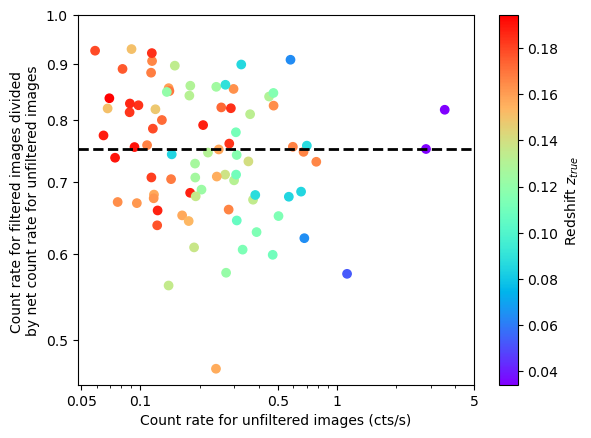

In [57]:
fraction = np.array(rates_filtered)/np.array(rates_unfiltered)
plt.scatter(rates_unfiltered, fraction, color = zxs_colour)
plt.axhline(np.mean(fraction), ls='--', lw=2, color='black')
plt.xscale("log")
plt.yscale("log")
plt.colorbar(mappable=mapperzxs, label='Redshift $z_{true}$')
plt.xticks([0.05, 0.1, 0.5, 1, 5], [0.05, 0.1, 0.5, 1, 5])
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#plt.ylim(0.4, 1)
plt.ylabel("Count rate for filtered images divided \nby net count rate for unfiltered images")
plt.xlabel("Count rate for unfiltered images (cts/s)")
plt.show()

`x.Model("atable{RRCS_DB.fits}", setPars={1: current_cluster_num, 2: 1.0, 3: (D_A.value/100)**2}, sourceNum=1)
 `

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19787,83,0.926032,0.822913,0.526959,0.02605,3.766600e+14,0.034717,0.033992,1.682650e+14,676.952,5.699780e+12,1.686950e+13,2.84568,0.951228,0.000004,2.866160e+14,1097.25,0


<Figure size 640x480 with 0 Axes>

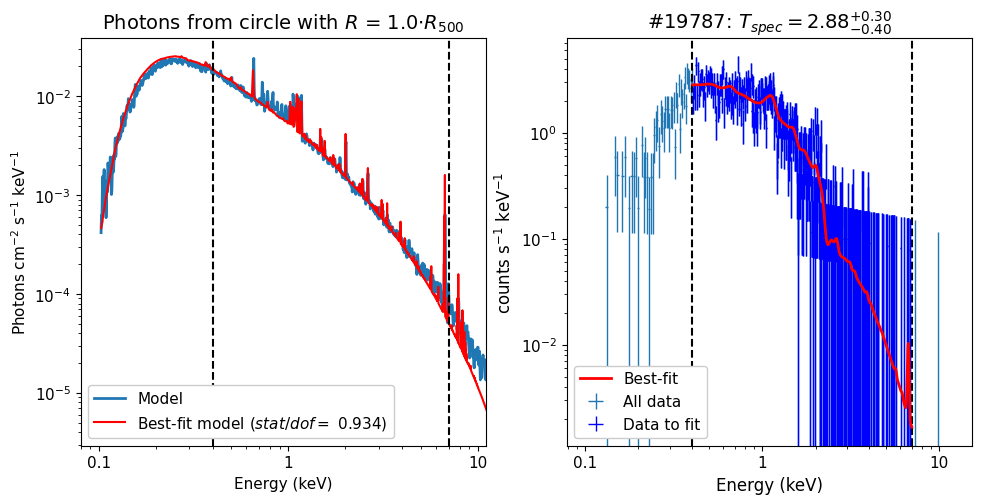

((2.8774289689811217, 2.58100865563921, 3.276413363109607), (0.33646659867702705, 0.0, 0.0, 0.007799153792660751, 0.0, 0.0), 1.1274808308247983, 0.3)

1 file 1 spectrum 
Spectrum 1  Spectral Data File: fakeit_19787_4830_29159.pha
Net count rate (cts/s) for Spectrum:1  2.787e+00 +/- 5.279e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  58-722
  Telescope: eROSITA Instrument: TM1  Channel Type: PI
  Exposure Time: 1000 sec
 Using fit statistic: cstat
 Using Response (RMF) File            ../erosita/erosita_pirmf_v20210719.rmf for Source 1
 Using Auxiliary Response (ARF) File  ../erosita/tm1_arf_open_000101v02.fits


Parameters defined:
Model phabs<1>*apec<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000E-02  frozen
   2    2   apec       kT         keV      2.87743      +/-  0.188607     
   3    2   apec       Abundanc            0.300000     frozen
   4    2   apec       Redsh

In [14]:
%run -i 'utils/scripts.py'

#logFile = x.Xset.openLog("newLogFile.txt")

cl_num = 19787

display(clusters[clusters.index==cl_num])

plt.figure(figsize=(11.5, 5.3))

SP = create_spectrum_and_fit_it(cl_num, 
                                borders=[0.4, 7.0], 
                                BACKGROUND=False, 
                                inside_radius=RRR,
                                dbr=True,
                                Xplot=False, plot=True, draw_only=False)

#plt.savefig('figures/obs_ex_5.pdf', format='pdf', bbox_inches='tight')

plt.show()

print(SP)

x.AllData.show()
x.AllModels.show()

##### The use of the $\chi^2$ statistic for evaluating the goodness of fit. 

The data here are a series of observations of the luminosity of a star, with known error bars. Our model assumes that the brightness of the star does not vary; that is, all the scatter in the data is due to measurement error. $\chi^2_{\rm dof} \approx 1$ indicates that the model fits the data well (upper-left panel). $\chi^2_{\rm dof}$ much smaller than 1 (upper-right panel) is an indication that the errors are overestimated. $\chi^2_{\rm dof}$ much larger than 1 is an indication either that the errors are underestimated (lower-left panel) or that the model is not a good description of the data (lower-right panel). In this last case, it is clear from the data that the star’s luminosity is varying with time: this situation is be treated more fully in chapter 10. [Source](https://www.astroml.org/book_figures/chapter4/fig_chi2_eval.html)

[Kaastra (2017): On the use of C-stat in testing models for X-ray spectra](https://www.aanda.org/articles/aa/pdf/2017/09/aa29319-16.pdf)

[Dos and don’ts of reduced chi-squared](https://arxiv.org/pdf/1012.3754.pdf)

## (B)  Draw all 84 clusters

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='IMAGE')

plt.savefig('panels_filtered.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

## (B0) Create `atable` for `xspec` with all 84 clusters

https://github.com/mbursa/xspec-table-models

`from xspec_table_models import XspecTableModelAdditive`

In [ ]:
%run -i 'utils/xspec_table_models.py'

radii = [0.15, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]  # in units of projected R_500

def atablemodel_input(CL_NUM, RADIUS):
    
    #plt.figure(figsize=(11,5))
    pho_list = extract_photons_from_cluster(CL_NUM, r = RADIUS, draw=False)
    #create_spectrum_and_fit_it(CL_NUM, borders=[0.4, 7.0], BACKGROUND=False, inside_radius=RADIUS,
    #                            Xplot=False, plot=True, draw_only=False)
    #plt.show()
    
    photons1, energies_bins1 = np.histogram(pho_list["ENERGY"], bins = binning1)

    # specific fluxes [erg/s/cm2/keV] for the grid of energies1
    spec_flux = [a*b*(1.6*10**(-9))/10000/1000/c for a, b, c in zip(photons1, energies1, dE1)]
    
    return [ sf * scale_by_distance(CL_NUM) for sf in spec_flux]

def scale_by_distance(CL_NUM): # normalization at 100 Mpc (z~0.024)
    
    D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(clusters.loc[CL_NUM]["z_true"]) # Mpc
    
    return (D_A.value/100)**2

N_channels1 = 4096
binning1 = np.logspace(np.log10(0.1), np.log10(12.0), N_channels1+1)
energies1 = [(a+b)/2 for a, b in zip(binning1[:-1], binning1[1:])]
dE1 = np.diff(binning1)

par1 = ('Number', list(clusters.index[:].values), False, True)
par2 = ('Radius', radii, False, True)

feets = XspecTableModelAdditive('RRCS_DB.fits', 'atableModel', np.array(energies1), [par1, par2], False)

index = 0
for cl_num in par1[1]:
    for radius in par2[1]:
        print(index, [cl_num, radius])
#for g in feets.generator():
#    index, param_values, param_indexes, energies = g
#    print(param_values)
        Iv = atablemodel_input(cl_num, radius)     # get the spectrum
        feets.write(index, Iv, False)    # write to FITS file
        index = index + 1

feets.save()

## (B1)  Fit  and draw all 84 clusters' spectra, with or without background

#### Considering: abundance = 0.3, cstat, exposure = 10000 s, weights = standard 

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='DATA')

plt.show()

## (B2)  Draw all 84 clusters' models (original and fitted), with or without background

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='MODEL')

plt.show()

## (C) Averaging

##### Check that abundance is FIXED (at 0.3 Solar) here:

In [56]:
%run -i 'utils/scripts.py'

#NNNN = 50
#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name = '0_clean_50_abund_free'

calculate_all_and_average_it(BACKGROUND=False, write_to_file=table_name)

171:   0%|          | 0/50 [00:00<?, ?it/s]

2471:   0%|          | 0/50 [00:00<?, ?it/s]

1838:   0%|          | 0/50 [00:00<?, ?it/s]

2904:   0%|          | 0/50 [00:00<?, ?it/s]

4613:   0%|          | 0/50 [00:00<?, ?it/s]

1245:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


1245 done



1380:   0%|          | 0/50 [00:00<?, ?it/s]

2471 done



2593:   0%|          | 0/50 [00:00<?, ?it/s]

4613 done



4967:   0%|          | 0/50 [00:00<?, ?it/s]

1838 done



2270:   0%|          | 0/50 [00:00<?, ?it/s]

2904 done



3155:   0%|          | 0/50 [00:00<?, ?it/s]

171 done



187:   0%|          | 0/50 [00:00<?, ?it/s]

2593 done



2603:   0%|          | 0/50 [00:00<?, ?it/s]

1380 done



1707:   0%|          | 0/50 [00:00<?, ?it/s]

2270 done



2386:   0%|          | 0/50 [00:00<?, ?it/s]

3155 done



3886:   0%|          | 0/50 [00:00<?, ?it/s]

187 done



350:   0%|          | 0/50 [00:00<?, ?it/s]

4967 done



5326:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


2603 done



2815:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


1707 done



1819:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


350 done



820:   0%|          | 0/50 [00:00<?, ?it/s]

3886 done



3985:   0%|          | 0/50 [00:00<?, ?it/s]

5326 done



5443:   0%|          | 0/50 [00:00<?, ?it/s]

2386 done



2421:   0%|          | 0/50 [00:00<?, ?it/s]

2815 done



6001:   0%|          | 0/50 [00:00<?, ?it/s]

1819 done



6695:   0%|          | 0/50 [00:00<?, ?it/s]

820 done



7364:   0%|          | 0/50 [00:00<?, ?it/s]

3985 done



8211:   0%|          | 0/50 [00:00<?, ?it/s]

5443 done



9636:   0%|          | 0/50 [00:00<?, ?it/s]

2421 done



10551:   0%|          | 0/50 [00:00<?, ?it/s]

6001 done



6496:   0%|          | 0/50 [00:00<?, ?it/s]

6695 done



6740:   0%|          | 0/50 [00:00<?, ?it/s]

7364 done



7409:   0%|          | 0/50 [00:00<?, ?it/s]

8211 done



8930:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


9636 done



9836:   0%|          | 0/50 [00:00<?, ?it/s]

10551 done



10820:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


6496 done



6529:   0%|          | 0/50 [00:00<?, ?it/s]

7409 done



7553:   0%|          | 0/50 [00:00<?, ?it/s]

9836 done



10018:   0%|          | 0/50 [00:00<?, ?it/s]

6740 done



7191:   0%|          | 0/50 [00:00<?, ?it/s]

8930 done



9240:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


10820 done



10842:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


6529 done



6582:   0%|          | 0/50 [00:00<?, ?it/s]

7553 done



7996:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


10018 done



10548:   0%|          | 0/50 [00:00<?, ?it/s]

7191 done



7308:   0%|          | 0/50 [00:00<?, ?it/s]

9240 done



9389:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


10842 done



10928:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


6582 done



11141:   0%|          | 0/50 [00:00<?, ?it/s]

10548 done



11599:   0%|          | 0/50 [00:00<?, ?it/s]

7996 done



13334:   0%|          | 0/50 [00:00<?, ?it/s]

7308 done



14434:   0%|          | 0/50 [00:00<?, ?it/s]

9389 done



14726:   0%|          | 0/50 [00:00<?, ?it/s]

10928 done



16666:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


11141 done



11272:   0%|          | 0/50 [00:00<?, ?it/s]

11599 done



11847:   0%|          | 0/50 [00:00<?, ?it/s]

14434 done



14559:   0%|          | 0/50 [00:00<?, ?it/s]

13334 done



13675:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


14726 done



14857:   0%|          | 0/50 [00:00<?, ?it/s]

16666 done



17017:   0%|          | 0/50 [00:00<?, ?it/s]

11272 done



11428:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


11847 done



12045:   0%|          | 0/50 [00:00<?, ?it/s]

13675 done



13751:   0%|          | 0/50 [00:00<?, ?it/s]

14559 done



14660:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


14857 done



14936:   0%|          | 0/50 [00:00<?, ?it/s]

17017 done



17086:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


11428 done



11468:   0%|          | 0/50 [00:00<?, ?it/s]

12045 done



12296:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


13751 done



14038:   0%|          | 0/50 [00:00<?, ?it/s]

14660 done



14667:   0%|          | 0/50 [00:00<?, ?it/s]

14936 done



15138:   0%|          | 0/50 [00:00<?, ?it/s]

done 17086



17174:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


12296 done



17365:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


11468 done



17654:   0%|          | 0/50 [00:00<?, ?it/s]

14038 done



18610:   0%|          | 0/50 [00:00<?, ?it/s]

14667 done
15138 done
17174 done
17654 done



17964:   0%|          | 0/50 [00:00<?, ?it/s]

17365 done



17415:   0%|          | 0/50 [00:00<?, ?it/s]

18610 done



19523:   0%|          | 0/50 [00:00<?, ?it/s]

17964 done



18073:   0%|          | 0/50 [00:00<?, ?it/s]

17415 done



17421:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


19523 done



19771:   0%|          | 0/50 [00:00<?, ?it/s]

17421 done



17638:   0%|          | 0/50 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.


18073 done



18589:   0%|          | 0/50 [00:00<?, ?it/s]

19771 done



19787:   0%|          | 0/50 [00:00<?, ?it/s]

17638 done
18589 done
19787 done


  0%|          | 0/84 [00:00<?, ?it/s]

,$T_{500}$,$T_{spec}$,$\Delta T_{spec}$,$L_{bol}$,$L_{fit}$,$\Delta L_{fit}$,$E_{av}$,$\Delta E_{av}$,$Z$,$\Delta Z$
171,2.44633,2.273172,0.390597,0.707698,0.301308,0.008206,1.094418,0.023905,0.214784,0.085012
187,2.43074,2.288510,0.294611,0.532571,0.233702,0.007791,1.079330,0.021640,0.170421,0.081540
350,3.21771,3.169385,0.332796,1.515690,0.530222,0.010907,1.136152,0.017143,0.308983,0.089856
820,3.57076,3.935015,0.529103,0.972861,0.337796,0.010359,1.167819,0.021111,0.397938,0.136221
1245,2.78095,2.926041,0.466094,0.452088,0.202694,0.006767,1.122753,0.024520,0.288105,0.156319
...,...,...,...,...,...,...,...,...,...,...
18589,2.22808,1.940943,0.131342,0.537683,0.220673,0.003005,1.062116,0.010617,0.140010,0.025667
18610,2.26553,2.073518,0.147944,0.455429,0.179995,0.002789,1.060821,0.011061,0.101675,0.025487
19523,2.39539,2.564417,0.259093,0.231120,0.079739,0.002663,1.095120,0.019278,0.175038,0.098404
19771,2.61661,2.822725,0.084456,0.651073,0.243466,0.001788,1.117591,0.004861,0.244071,0.025742


In [72]:
np.array(read_table[10].values())

array(dict_values([0.0850122174824953, 0.0815402522500625, 0.0898559592580732, 0.1362209267873557, 0.1563190240728884, 0.0715353781082503, 0.1325674962196697, 0.103464734673809, 0.0864104274933525, 0.1403665756321561, 0.0543223645506804, 0.1075408586169685, 0.1141470252994546, 0.1244293300901376, 0.1730107844950283, 0.0540580277510241, 0.0846436737347617, 0.0569500772457258, 0.1141172756802568, 0.1052257636495788, 0.4292614359579276, 0.1450088406680685, 0.1813154091165569, 0.1622720580450512, 0.1523156774114954, 0.1765660784957925, 0.1029316567684149, 0.0927855883354058, 0.2169665577126098, 0.0589637206187626, 0.091903939953548, 0.1493453564264044, 0.133572234853549, 0.0750740899035343, 0.161916906640201, 0.0544709385837222, 0.1342462316179019, 0.2200481227303398, 0.0317564152357524, 0.0580525933243273, 0.0309718192350622, 0.0859758596432006, 0.0466907347035679, 0.1092296562391382, 0.0643634104933401, 0.0444081181612941, 0.0655785543678448, 0.1090248359967898, 0.1056233192432997, 0.064

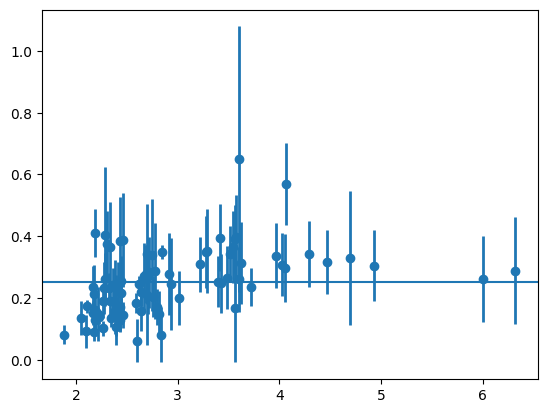

In [78]:
plt.errorbar(read_table[1].values(), read_table[9].values(), yerr=list(read_table[10].values()), lw=0, elinewidth=2)
plt.scatter(read_table[1].values(), read_table[9].values())
plt.axhline(np.mean(list(read_table[9].values())))

In [80]:
np.mean(list(read_table[9].values()))

0.25194364886456394

#### Reading from table:

In [57]:
NNNN = 50

#table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)
table_name = '0_clean_50_abund_free'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr =  list(zip(read_table[7].values(), read_table[8].values()))

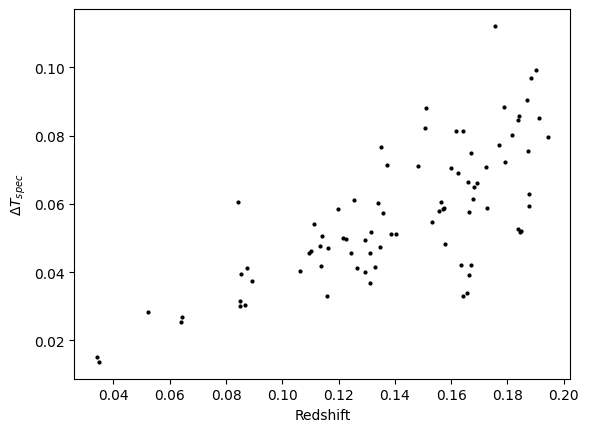

In [46]:
plt.plot(redshifts, [a[1] for a in aven_usr], 'o', markersize=2, color='black')
#plt.errorbar(redshifts, [a[1] for a in temp_usr], 
#             yerr=[a[2] for a in temp_usr], lw=0, elinewidth=1, capsize=1, color='black')
plt.xlabel("Redshift")
plt.ylabel("$\Delta T_{spec}$")
plt.show()

### (C0) Spectral temperature compared to $T_{500}$

In [18]:
#DAS = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(redshifts).value # Mpc
#(DAS*[1+qwerty for qwerty in redshifts])**2/100000 # Mpc^2
#plt.scatter(DAS*[1+qwerty for qwerty in redshifts], (DAS*[1+qwerty for qwerty in redshifts])**2/100000 )
#plt.xlabel("$D_{comoving} = D_A \cdot (1+z), Mpc$", fontsize=12)
#plt.ylabel("$[D_A (1+z)]^2 \cdot 10^{-5}, Mpc^2$", fontsize=12)

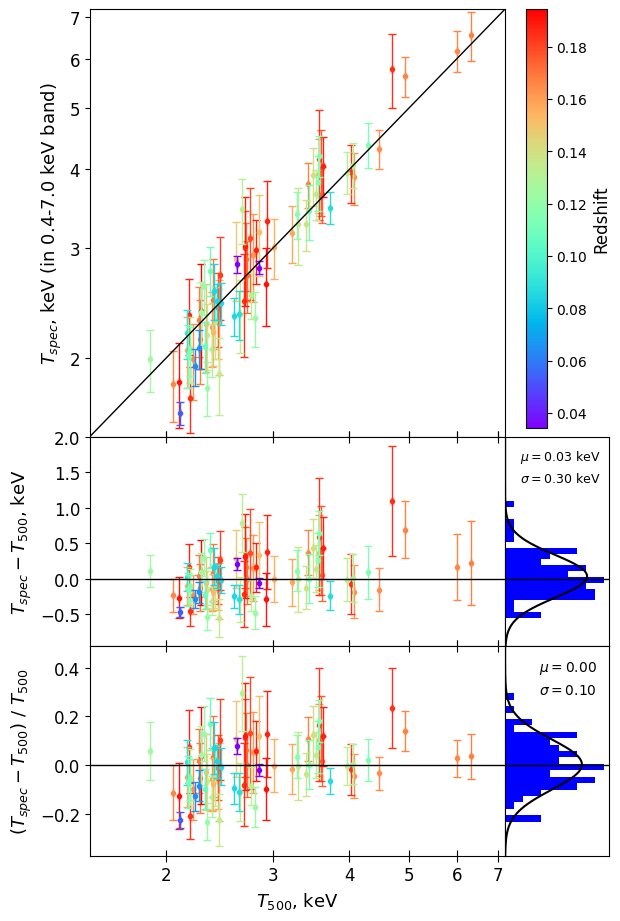

In [58]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

t500s = list(zip(np.zeros(len(temp_usr)), [a[0] for a in temp_usr], np.zeros(len(temp_usr))))

draw_three_panels_vertical(x_array=t500s,
                  y_array=temp_usr,
                  x_label="$T_{500}$, keV",
                  y_label_left="$T_{spec}$, keV (in 0.4-7.0 keV band)",
                  y_label_right_up="$T_{spec} - T_{500}$, keV",
                  y_label_right_down="$(T_{spec} - T_{500}) \ / \ T_{500}$",
                  clr='b',
                  NnNn=NNNN,
                  cmap=redshifts,
                  cmap_label="Redshift")

#plt.savefig('figures/T_vs_T500_vertical.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 2471, 6695

### (C1) Temperature and luminosity from fit as a functions of $T_{500}$ and $L_{500}$ from several fits.

In [20]:
masses = [clusters.loc[i]["M500"]/10**14 for i in clusters.index]
norm = matplotlib.colors.Normalize(vmin=min(masses), vmax=max(masses), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
mass_colour = np.array([(mapper.to_rgba(v)) for v in masses])

<Figure size 640x480 with 0 Axes>

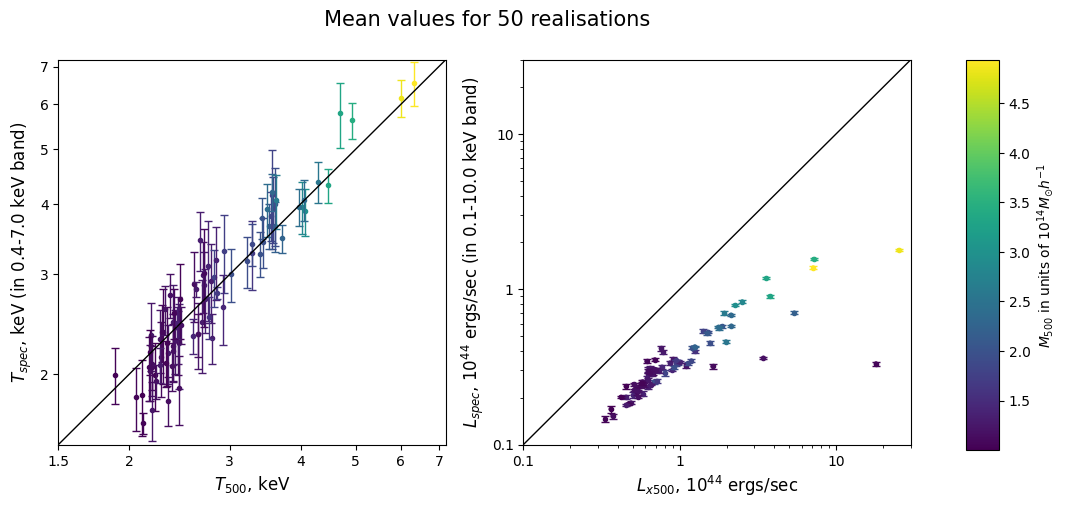

In [59]:
%run -i 'utils/functions.py'

plt.figure(figsize=(11,5))

plt.suptitle(f"     Mean values for {NNNN} realisations", fontsize=15)

plt.subplot(121)

xx = [a[0] for a in temp_usr]
yy = [a[1] for a in temp_usr]
y_err = [a[2] for a in temp_usr]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.ylabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)

plt.xlim(1.5, 7.2)
plt.ylim(1.5, 7.2)

plt.xscale("log")
plt.yscale("log")

plt.xticks([plt.gca().get_xlim()[0],2,3,4,5,6,7], [plt.gca().get_xlim()[0],2,3,4,5,6,7])
plt.yticks([2,3,4,5,6,7], [2,3,4,5,6,7])

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

#plt.scatter(2.60178, 3.985203132730008, color='red')

plt.subplot(122)

xx = [a[0] for a in lumin_usr]
yy = np.array([a[1] for a in lumin_usr])#*np.array([E(rr) for rr in redshifts]) #*(np.ones(len(redshifts))+redshifts)**2
y_err = [a[2] for a in lumin_usr]#*np.array([E(rr) for rr in redshifts]) #*(np.ones(len(redshifts))+redshifts)**2

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.ylabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.15, 30)
plt.ylim(0.15, 30)

plt.xticks([0.1, 1, 10], [0.1, 1, 10])
plt.yticks([0.1, 1, 10], [0.1, 1, 10])

#plt.axvline(0.592084)
#plt.axhline(0.2546419982104965)

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

#plt.savefig('figures/T_vs_T_and_L_vs_L.pdf', format='pdf')

plt.show()

#L-T, L-M, T-M

#### Note how small are errors for luminosities!

Beta: [3.63869845 0.73954765]
Beta Std Error: [0.15838888 0.03700322]
Beta Covariance: [[2.03551802e-04 4.32914168e-05]
 [4.32914168e-05 1.11097560e-05]]
Residual Variance: 123.2464511147976
Inverse Condition #: 0.08553486038131387
Reason(s) for Halting:
  Sum of squares convergence
0.20740570988489124 0.32859380525671994


<Figure size 640x480 with 0 Axes>

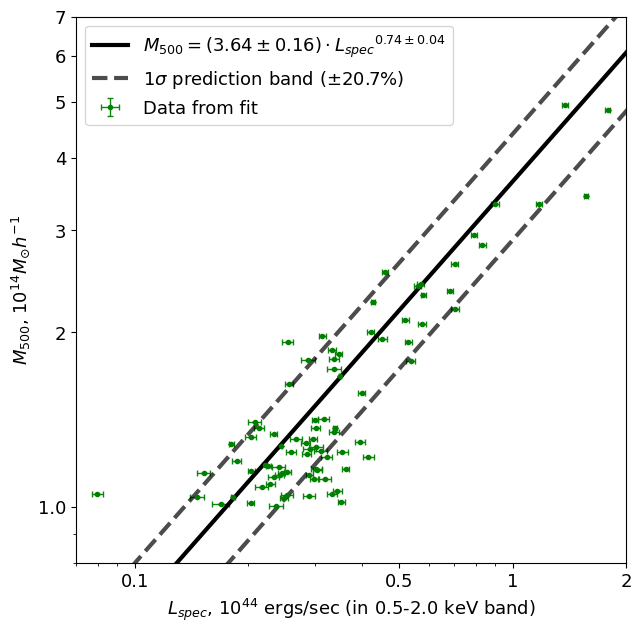

In [60]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'
%run -i 'utils/functions.py'

plt.figure(figsize=(7.1,7.1))

yyy = np.array([a[1] for a in lumin_usr])#/E(np.array(zxs))
yyy_err = np.array([a[2] for a in lumin_usr])#/E(np.array(zxs))

#yyy0520 = np.array([a[1] for a in lumin_usr0520])#/E(np.array(zxs))
#yyy_err0520 = np.array([a[2] for a in lumin_usr0520])/E(np.array(zxs))
#chastnoye = yyy/yyy0520
#chastnoye_err = chastnoye*(yyy_err/yyy + yyy_err0520/yyy0520)

lll = np.linspace(0.05, 3., 100)

draw_line(yyy, yyy_err, masses, np.array(masses)*0, 
          clr = 'green', 
          l4dots = 'Data from fit', 
          l4legend = 'M_{{500}}',
          argument = 'L_{spec}', 
          with_scatter=True)

#ae = rebin_scatterplot(yyy, masses, NBINS=15, cornerplot=False)

#plt.errorbar(ae[0], ae[2], xerr=ae[1], yerr=np.array(ae[2])*0, 
#             linewidth=0, marker='o', markersize=4, alpha=0.95,
#             elinewidth=2, capsize=3, color="r")                 

plt.ylabel("$M_{500}$, $10^{14} M_{\odot} h^{-1}$", fontsize=13)
plt.xlabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.5-2.0 keV band)", fontsize=13)
#plt.ylabel("Factor = $L_{spec}$ (0.1-10.0 keV)  /  $L_{spec}$ (0.5-2.0 keV)", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([1.0, 2, 3, 4, 5, 6, 7], [1.0, 2, 3, 4, 5, 6, 7], size=13)
plt.xticks([0.1, 0.5, 1, 2], [0.1, 0.5, 1, 2], size=13)
#plt.yticks([2, 3], [2, 3], size=13)

plt.xlim(0.07, 2.0)

plt.legend(fontsize=13, loc=2)

#plt.gca().add_patch(Rectangle((0.07, 0.4), 0.15, 0.5, linewidth=1, 
#                              edgecolor='w', facecolor='w', fill=True, zorder=2))

plt.ylim(0.8, 7)

#plt.scatter(masses, [a[0] for a in lumin_usr])
#plt.scatter(masses, 1.056 * 0.704**(-2) * (np.array(masses)/3.9)**1.61 * E(np.array(zxs))**(.85))

#plt.savefig('figures/L_vs_M_reversed.pdf', format='pdf')

plt.show()

### (C2) Average energy as a function of **mean** temperature

##### aven_usr: [ $E_{av}, \Delta E$ ], temp_usr: [ $T_{sim}, T_{spec}, \Delta T$ ]

[How to get confidence intervals from curve_fit](https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit)

[Correct fitting with scipy curve_fit including errors in x?](https://stackoverflow.com/questions/26058792/correct-fitting-with-scipy-curve-fit-including-errors-in-x)

[How to plot 1-Sigma Prediction Interval for scipy.odr](https://stackoverflow.com/questions/60889680/how-to-plot-1-sigma-prediction-interval-for-scipy-odr)

[Confidence interval for exponential curve fit](https://stackoverflow.com/questions/24633664/confidence-interval-for-exponential-curve-fit/37080916#37080916)

Beta: [1.32423784 6.91340987]
Beta Std Error: [0.03887094 0.23645293]
Beta Covariance: [[ 0.00144353 -0.00829876]
 [-0.00829876  0.05341508]]
Residual Variance: 1.0467079341268108
Inverse Condition #: 0.048561723311259505
Reason(s) for Halting:
  Sum of squares convergence
0.09585554015007608 0.013732971359450482


<Figure size 640x480 with 0 Axes>

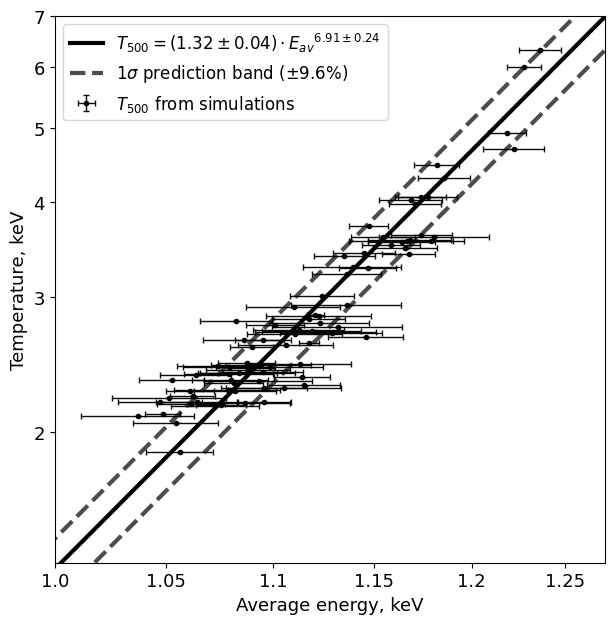

In [61]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

xx = [a[0] for a in aven_usr]
x_err = [a[1] for a in aven_usr]
yy1 = [a[0] for a in temp_usr]
yy2 = [a[1] for a in temp_usr]
y2_err = [a[2] for a in temp_usr]

lll = np.linspace(0.9, 1.5, 100)        

#draw_line(xx, x_err, yy2, y_es=y2_err, 
#          clr = 'blue', 
#          l4dots = '$T_{spec}$ from fit', 
#          l4legend = 'T_{{spec}}',
#          argument='E_{{av}}',
#          with_intervals = True,
#          with_scatter=True)

draw_line(xx, np.array(x_err), yy1, y_es=np.array(yy1)*0, 
          clr = 'black', 
          l4dots = '$T_{500}$ from simulations', 
          l4legend = 'T_{{500}}',
          argument='E_{{av}}',
          with_scatter=True)        
        
plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

Xtix = [1.00, 1.05, 1.10, 1.15, 1.2, 1.25]
Ytix = [2,3,4,5,6,7]

plt.ylim(1.35, 7)
plt.xlim(1.0, 1.272)

plt.xticks(Xtix, Xtix, size=13)
plt.yticks(Ytix, Ytix, size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.4, marker='o', markersize=4)

#plt.grid()

plt.legend(loc=2, fontsize = 12)

ooofff = (plt.gca().get_xlim(), plt.gca().get_ylim())

#plt.savefig('figures/T_vs_Eav-N.pdf', format='pdf', bbox_inches='tight')
plt.show()

#yy234 = yy1-1.36*np.array(xx)**6.8
#xx234 = xx

#plt.figure(figsize=(7, 4))
#plt.scatter(xx, yy1)
#plt.xscale("log")
#plt.yscale("log")
#plt.xticks(Xtix, Xtix, size=13)
#plt.scatter(xx, xx11)
#plt.axhline(0, color='red', ls='--')
#plt.show()

In [31]:
#%run -i 'utils/draw.py'
#calculate_scatter(xx, yy2, plot=True)

#### Testing `apec` models vs our data

In [25]:
plt.figure(figsize=(7.1,7.1))

xxx = [a[0] for a in aven_usr]
xxx_err = [a[1] for a in aven_usr]

yyy0 = [a[0] for a in temp_usr]

yyy = [a[1] for a in temp_usr]
yyy_err = [a[2] for a in temp_usr]

lll = np.linspace(1.04, 1.24, 100) 

def TfE(eav):
    return 1.35*np.array(eav)**6.8

temps7 = TfE(xxx)           # better consistency
avens7 = np.zeros(84)
redshifts7 = zxs

x.Plot.device = "/null"

for i in tqdm(range(84)):
    
    x.Xset.chatter = 0
    x.Model("phabs*apec", setPars={1:0.01, 2:temps7[i], 3:0.3, 4:0, 5:1})
    #x.Plot("model")
    
    x.AllData.clear()
    fs = x.FakeitSettings(response = '../erosita/erosita_pirmf_v20210719.rmf', 
                               arf = '../erosita/tm1_arf_open_000101v02.fits', 
                        background = '', 
                          exposure = 1000, 
                        correction = '', 
                      backExposure = '', 
                          fileName = 'fakeit.pha')
    x.AllData.fakeit(nSpectra = 1, 
                     settings = fs, 
                   applyStats = True,
                   filePrefix = "",
                      noWrite = False)

    x.AllData.ignore(f"**-{0.4} {7.0}-**")
    x.Plot.xAxis = "keV"
    x.Plot("data")

    s_i = x.AllData(1).values
    ens = x.AllData(1).energies
    E_i = [(e[0]+e[1])/2 for e in ens]
    av_en = np.dot(E_i, s_i)/np.sum(s_i)    
    
    x.Xset.chatter = 10
    
    avens7[i] = av_en

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 710x710 with 0 Axes>

<Figure size 640x480 with 0 Axes>

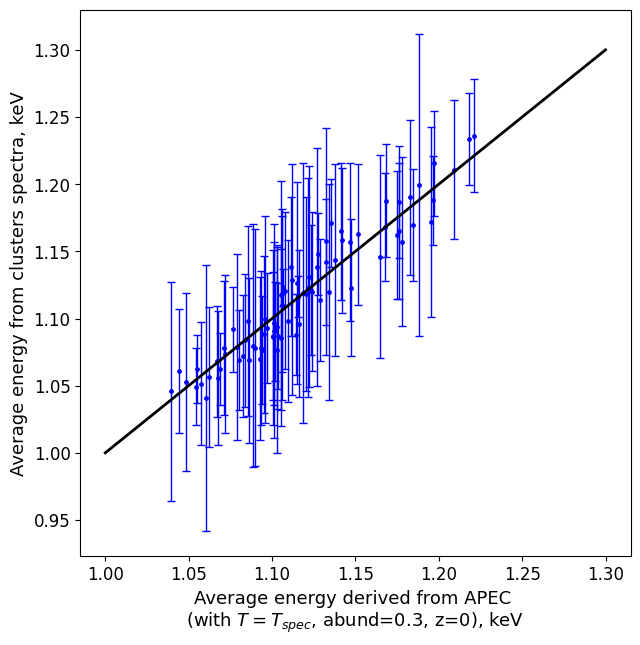

In [26]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

plt.scatter(avens7, xxx, marker='o', s=6, color='b')
plt.errorbar(avens7, xxx, xxx_err, lw=0, elinewidth=1, capsize=3, color='b')
plt.plot([1, 1.3], [1, 1.3], color='black', linewidth=2)
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Average energy derived from APEC \n(with $T=T_{spec}$, abund=0.3, z=0), keV", fontsize=13)
plt.ylabel("Average energy from clusters spectra, keV", fontsize=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

<Figure size 640x480 with 0 Axes>

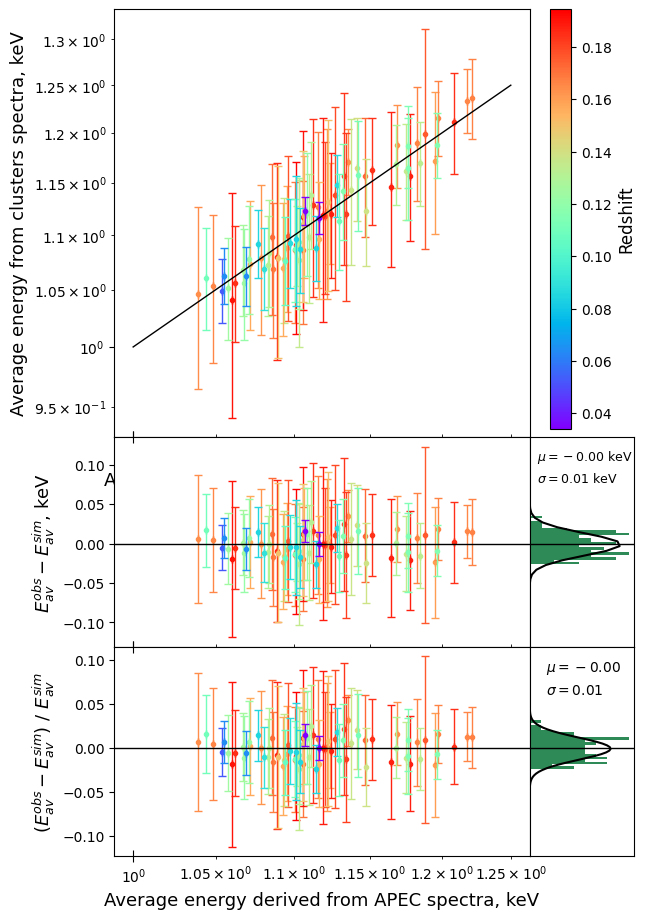

In [30]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels_vertical(x_array=list(zip(np.zeros(len(temp_usr)), avens7, np.zeros(len(avens7)))), 
                  y_array=list(zip(np.zeros(len(temp_usr)), xxx, xxx_err)),
                  x_label="Average energy derived from APEC spectra, keV",
                  y_label_left="Average energy from clusters spectra, keV",
                  y_label_right_up="$E_{av}^{obs} - E_{av}^{sim}$, keV",
                  y_label_right_down="$(E_{av}^{obs} - E_{av}^{sim}) \ / \ E_{av}^{sim}$",
                  clr='seagreen',
                  NnNn = NNNN,
                  cmap = redshifts,
                  cmap_label="Redshift")

#plt.savefig('figures/Eav_vs_Eav_vertical.pdf', format='pdf', bbox_inches='tight')

plt.show()

## (G) Adding background

[ABSOLUTE MEASUREMENT OF THE UNRESOLVED COSMIC X-RAY BACKGROUND
IN THE 0.5–8 KEV BAND WITH CHANDRA](https://arxiv.org/pdf/astro-ph/0512542.pdf)

[CHANDRA SPECTRA OF THE SOFT X-RAY DIFFUSE BACKGROUND](https://iopscience.iop.org/article/10.1086/345347/pdf)

`'5_ab-fix_cstat_10ks_standard_BKG-50_with_area'`

In [ ]:
%run -i 'utils/scripts.py'

NNNN = 10

calculate_all_and_average_it(BACKGROUND=True, write_to_file='5_with_bkg_10_test1')

#### Concatenate 5 lists with averaging by 10 realisations each:

In [13]:
all_files = pd.DataFrame()

for tn in [1,2,3,4,5]:
    
    table_name = '5_with_bkg_10_'+str(tn)

    file1 = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ')

    #display(file1)
    all_files = pd.concat([all_files, file1])

#display(all_files)

result = {}

for i in range(84):
    
    #display(all_files[i::84])
    
    #print(all_files[i::84].mean())
    
    result[clusters.index[i]] = all_files[i::84].mean()

    #display(pd.DataFrame(result[clusters.index[i]]).T)
result_df = pd.DataFrame(result).T

write_to_file = '5_with_bkg_50'

result_df.to_csv('tables/table_'+write_to_file+'.csv', sep=' ', header=False, index=True)

#### Reading from table:

In [55]:
NNNN = 10

#table_name = '5_ab-fix_cstat_10ks_standard_BKG-'+str(NNNN)+'_z=0'
table_name = '5_with_bkg_50'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_with_bkg =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_with_bkg = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_with_bkg =  list(zip(read_table[7].values(), read_table[8].values()))

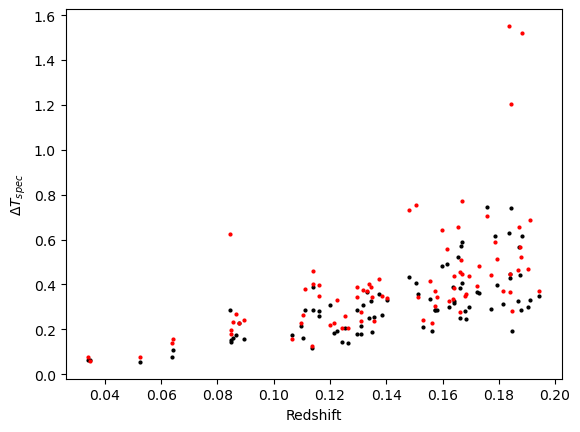

In [56]:
plt.plot(redshifts, [a[2] for a in temp_usr], 'o', markersize=2, color='black')
plt.plot(redshifts, [a[2] for a in temp_usr_with_bkg], 'o', markersize=2, color='red')
#plt.errorbar(redshifts, [a[1] for a in temp_usr], 
#             yerr=[a[2] for a in temp_usr], lw=0, elinewidth=1, capsize=1, color='black')
plt.xlabel("Redshift")
plt.ylabel("$\Delta T_{spec}$")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

#### Experiments with constant before background:

In [63]:
display(pd.DataFrame(read_table))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
171,2.44633,2.092206,0.303492,0.707698,0.574992,0.065527,1.089004,0.033608,27.841089,36.824995,8.617142,0.000731,0.000061,27.841089,0.0,0.0
187,2.43074,2.598199,0.372905,0.532571,0.492919,0.045137,1.077492,0.045939,24.458494,31.708549,6.878058,0.000584,0.000039,24.458494,0.0,0.0
350,3.21771,3.015206,0.342258,1.515690,1.280941,0.073412,1.132150,0.028072,34.715563,30.541311,10.066165,0.001422,0.000067,34.715563,0.0,0.0
820,3.57076,3.881721,0.643143,0.972861,0.914804,0.069532,1.169086,0.027685,32.525843,31.137148,7.771984,0.000904,0.000044,32.525843,0.0,0.0
1245,2.78095,2.875648,0.558518,0.452088,0.487147,0.047740,1.123887,0.050828,25.984376,22.135438,6.786078,0.000525,0.000039,25.984376,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,2.22808,2.182836,0.140469,0.537683,0.423273,0.018579,1.063778,0.014335,109.417501,150.849159,17.953093,0.003661,0.000110,109.417501,0.0,0.0
18610,2.26553,2.386848,0.158950,0.455429,0.342270,0.013081,1.055235,0.018327,114.070724,178.312600,17.290953,0.002830,0.000091,114.070724,0.0,0.0
19523,2.39539,2.836897,0.624977,0.231120,0.162892,0.016328,1.096877,0.043812,61.033100,77.306583,10.225090,0.000717,0.000048,61.033100,0.0,0.0
19771,2.61661,2.790874,0.077054,0.651073,0.544230,0.008324,1.116508,0.005945,359.968601,370.113926,34.191486,0.015735,0.000181,359.968601,0.0,0.0


In [64]:
area_usr_with_bkg = list(zip(read_table[9].values(), read_table[10].values(), read_table[11].values()))
norm_usr_with_bkg = list(zip(read_table[12].values(), read_table[13].values()))
#pbkg_usr_with_bkg = list(zip(read_table[14].values(), read_table[15].values(), read_table[16].values()))

ORIGA = np.array([n[0] for n in area_usr_with_bkg])
SPECA = np.array([n[1] for n in area_usr_with_bkg])
SPECA_delta = np.array([n[2] for n in area_usr_with_bkg])

NORM = np.array([n[0] for n in norm_usr_with_bkg])
NORM_delta = np.array([n[1] for n in norm_usr_with_bkg])

#ORIGB = np.array([n[0] for n in pbkg_usr_with_bkg])
#SPECB = np.array([n[1] for n in pbkg_usr_with_bkg])
#SPECB_delta = np.array([n[2] for n in pbkg_usr_with_bkg])

SKOLKO1 = SPECA/ORIGA
SKOLKO1_delta = SPECA_delta/ORIGA

#SKOLKO2 = SPECB/ORIGB
#SKOLKO2_delta = SPECB_delta/ORIGB

print(SKOLKO1)

[1.32268515 1.2964228  0.87975849 0.95730487 0.85187492 1.30602494
 0.46700077 0.8158218  1.5189179  1.05691083 1.52228348 0.66252503
 1.10052444 0.88764867 0.92037215 1.28983353 1.32902135 1.48139571
 1.13316845 1.19611433 0.69132108 0.95604727 1.06957312 0.87874276
 0.9056851  1.25182961 0.93424637 0.53745921 0.90334053 1.52880318
 1.24021016 0.94560019 0.7434852  1.30156213 1.15958707 1.72175116
 0.96097264 0.69450316 1.99380691 1.42216529 2.18385288 1.12422429
 1.38231041 1.02635913 1.16885614 1.68519819 1.2485534  1.04010081
 0.69461132 1.46595137 0.8112986  1.15338471 1.25694591 0.94838347
 1.11559166 1.06991492 1.32247073 1.31110648 1.02408668 0.94038723
 0.96836981 1.07906982 1.54416782 1.21729124 1.46291231 1.19059319
 1.01660632 1.25643235 1.11304991 0.92063204 1.61690819 0.94773263
 0.37308257 0.96933969 0.87829697 0.71457188 0.97049816 0.82216625
 1.51143866 1.37865659 1.56317583 1.26663372 1.02818392 0.79370764]


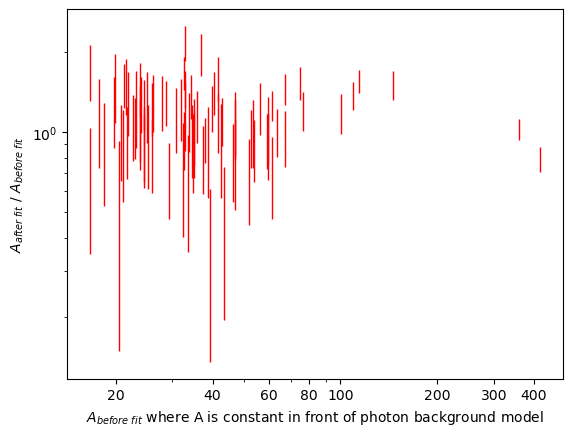

In [65]:
plt.errorbar(ORIGA, SKOLKO1, yerr=SKOLKO1_delta, elinewidth=1, fmt='none', color='red')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$A_{before \ fit}$ where A is constant in front of photon background model")
plt.ylabel("$A_{after \ fit} \ / \ A_{before \ fit}$")
xgtr = np.append(np.linspace(20, 100, 5).astype(int), [200,300,400])
plt.xticks(xgtr, xgtr)
#ygtr = [1,2,3,4,5,6,7]
#plt.yticks(ygtr, ygtr)
plt.show()

<Figure size 640x480 with 0 Axes>

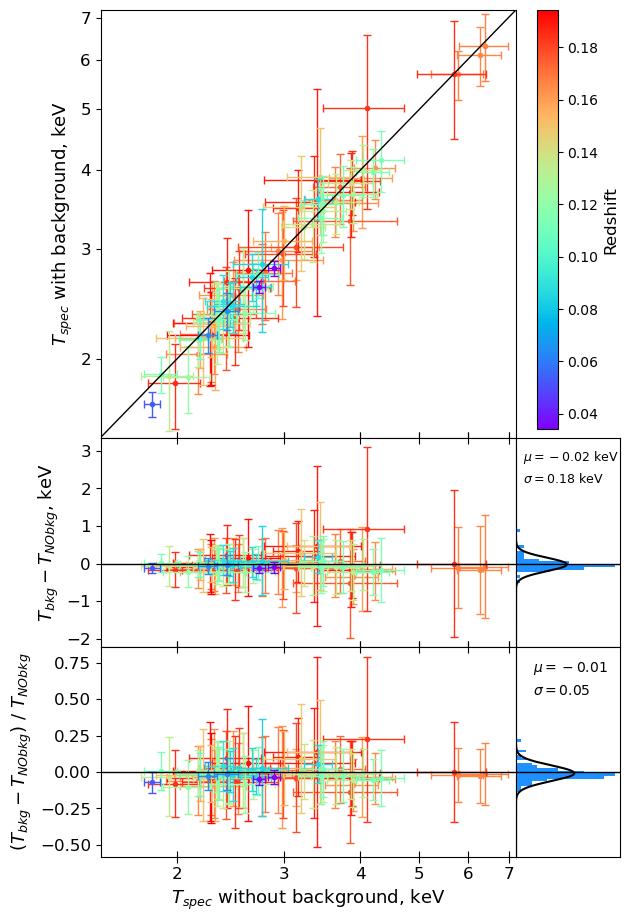

In [63]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels_vertical(x_array=temp_usr, 
                  y_array=temp_usr_with_bkg,
                  x_label="$T_{spec}$ without background, keV",
                  y_label_left="$T_{spec}$ with background, keV",
                  y_label_right_up="$T_{bkg} - T_{NObkg}$, keV",
                  y_label_right_down="$(T_{bkg} - T_{NObkg}) \ / \ T_{NObkg}$",
                  clr='dodgerblue',
                  NnNn = NNNN,
                  cmap = redshifts,
                  cmap_label="Redshift")

plt.savefig('figures/T_with_bkg_vs_T_without_bkg_vertical.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 6496

### Comparing clear $T$ and $L$ from fitting (not simulations) and them with background added:

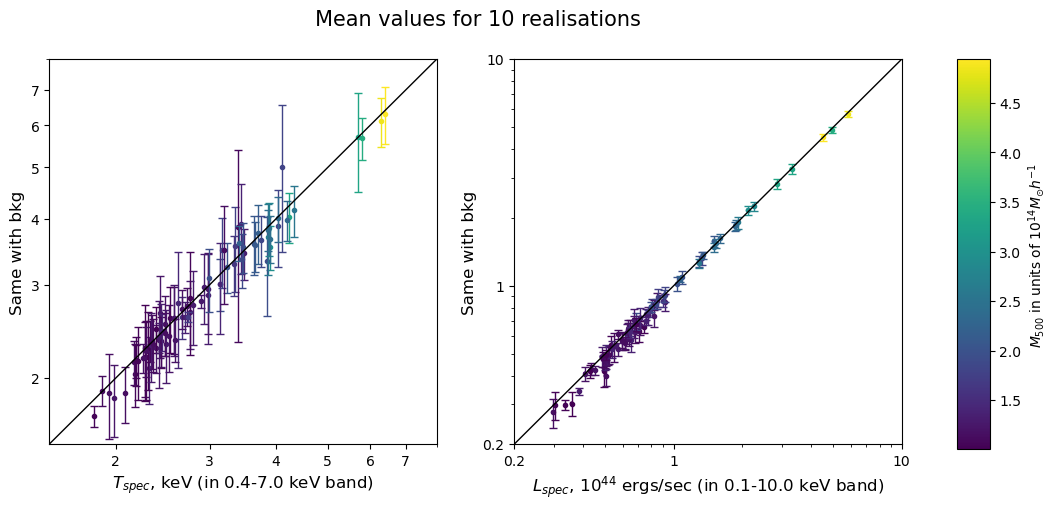

In [214]:
plt.figure(figsize=(11,5))

plt.suptitle(f"     Mean values for {NNNN} realisations", fontsize=15)

plt.subplot(121)

#xx = [a[0] for a in temp_usr_with_bkg]
xx = [a[1] for a in temp_usr]
yy = [a[1] for a in temp_usr_with_bkg]
y_err = [a[2] for a in temp_usr_with_bkg]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

#plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.xlabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)
plt.ylabel("Same with bkg", fontsize=12)

plt.xlim(1.5, 8)
plt.ylim(1.5, 8)

plt.xscale("log")
plt.yscale("log")

plt.xticks([2,3,4,5,6,7], [2,3,4,5,6,7])
plt.yticks([2,3,4,5,6,7], [2,3,4,5,6,7])

plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim(), color='black', linewidth=1)


plt.subplot(122)

#xx = [a[0] for a in lumin_usr_with_bkg]
xx = [a[1] for a in lumin_usr]
yy = [a[1] for a in lumin_usr_with_bkg] #/(np.ones(len(redshifts))+redshifts)**2 # *np.sqrt(NORM)
y_err = [a[2] for a in lumin_usr_with_bkg] #/(np.ones(len(redshifts))+redshifts)**2 # *np.sqrt(NORM)

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

#plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.xlabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=12)
plt.ylabel("Same with bkg", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.2, 10)
plt.ylim(0.2, 10)

plt.xticks([0.2, 1, 10], [0.2, 1, 10])
plt.yticks([0.2, 1, 10], [0.2, 1, 10])

plt.plot( plt.gca().get_xlim(), plt.gca().get_ylim(), color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

#plt.savefig('figures/T_vs_T_and_L_vs_L_with_bkg.pdf', format='pdf')
plt.show()

### OBSOLETE

Beta: [0.33293888 1.72726548]
Beta Std Error: [0.01454071 0.06304329]
Beta Covariance: [[ 1.09065862e-05 -3.86115246e-05]
 [-3.86115246e-05  2.05019587e-04]]
Residual Variance: 19.385738073542594
Inverse Condition #: 0.1230589016121512
Reason(s) for Halting:
  Sum of squares convergence
0.349368485944497 0.1632002118033037


<Figure size 640x480 with 0 Axes>

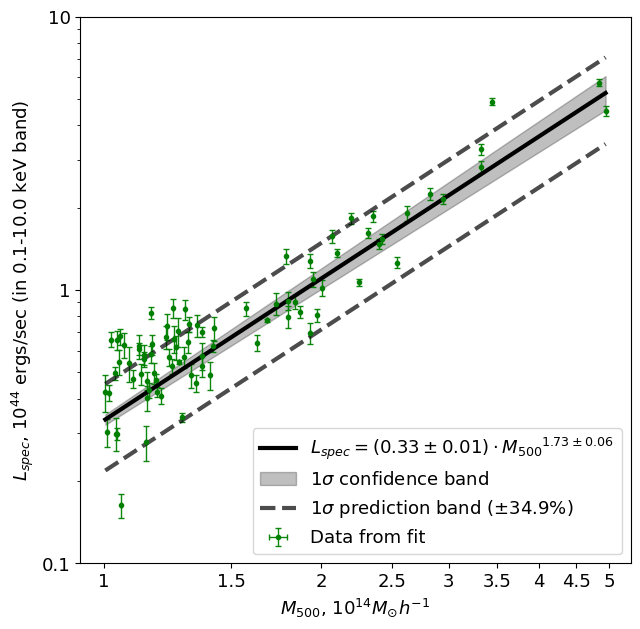

In [238]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

yyy = [a[1] for a in lumin_usr_with_bkg]
yyy_err = [a[2] for a in lumin_usr_with_bkg]

lll = np.linspace(min(masses), max(masses), 100)

draw_line(masses, np.array(masses)*0, yyy, yyy_err, 
          clr = 'black', 
          l4dots = 'Data from fit', 
          l4legend = 'L_{{spec}}',
          argument='M_{{500}}', 
          with_scatter=True)

plt.xlabel("$M_{500}$, $10^{14} M_{\odot} h^{-1}$", fontsize=13)
plt.ylabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=13)

plt.xscale("log")
plt.yscale("log")

plt.xticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([0.1, 1, 10], [0.1, 1, 10], size=13)

plt.legend(fontsize=13, loc=4)

plt.show()

### Average energy as a function of **mean** temperature with background added:

Beta: [1.28648925 7.1326723 ]
Beta Std Error: [0.03888338 0.23560277]
Beta Covariance: [[ 0.00331806 -0.01906173]
 [-0.01906173  0.12181969]]
Residual Variance: 0.4556624905997654
Inverse Condition #: 0.04733169655061585
Reason(s) for Halting:
  Sum of squares convergence
0.10359668061068494 0.014452766190953408
0.7023809523809523 0.2976190476190476 84


<Figure size 640x480 with 0 Axes>

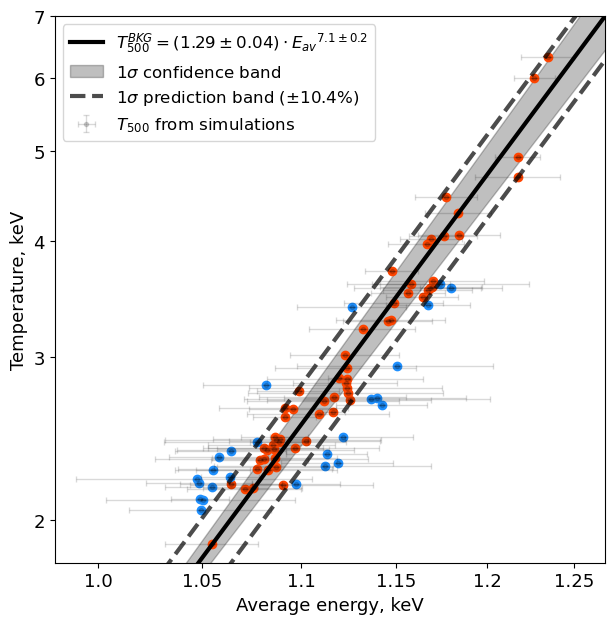

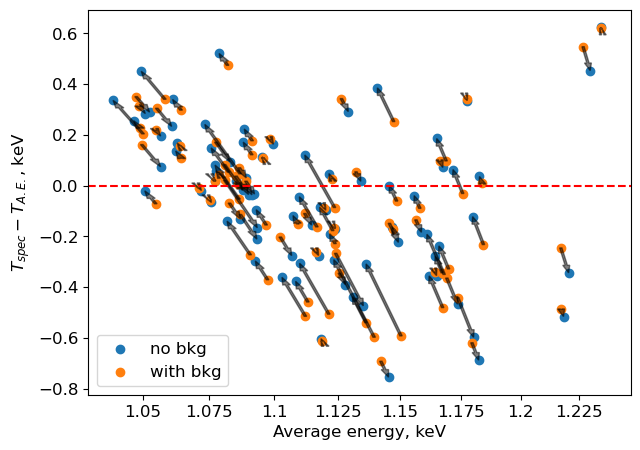

In [142]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

xx = [a[0] for a in aven_usr_with_bkg]
x_err = [a[1] for a in aven_usr_with_bkg]
yy1 = [a[0] for a in temp_usr_with_bkg]
yy2 = [a[1] for a in temp_usr_with_bkg]
y2_err = [a[2] for a in temp_usr_with_bkg]

lll = np.linspace(0.9, 1.5, 100)

#draw_line(xx, x_err, yy2, y_es=y2_err, 
#          clr = 'red', 
#          l4dots = '$T_{spec}$ from fit', 
#          l4legend = 'T_{{spec}}^{{BKG}}',
#          argument='E_{{av}}',
#          with_scatter=True)

draw_line(xx, x_err, yy1, y_es=np.array(yy1)*0, 
          clr = 'black', 
          l4dots = '$T_{500}$ from simulations', 
          l4legend = 'T_{{500}}^{{BKG}}',
          argument='E_{{av}}', 
          with_scatter=True)  

plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

Xtix = [1.00, 1.05, 1.10, 1.15, 1.2, 1.25]
Ytix = [2,3,4,5,6,7]

plt.xticks(Xtix, Xtix, size=13)
plt.yticks(Ytix, Ytix, size=13)

plt.ylim(1.8, 7)
plt.xlim(0.98, 1.268)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.5, marker='o', markersize=4)

plt.legend(loc=2, fontsize=12)

plt.savefig('figures/T_vs_Eav_with_bkg-N.pdf', format='pdf', bbox_inches='tight')

plt.show()

plt.figure(figsize=(7, 5))
#plt.scatter(xx, yy1)
plt.xscale("log")
#plt.yscale("log")
plt.xticks([1.00, 1.05, 1.075, 1.10, 1.125, 1.15, 1.175, 1.2, 1.225, 1.25], 
           [1.00, 1.05, 1.075, 1.10, 1.125, 1.15, 1.175, 1.2, 1.225, 1.25], size=12)
plt.yticks(size=12)
plt.scatter(xx234, yy234, label='no bkg')
plt.scatter(xx, yy1-1.36*np.array(xx)**6.8, label='with bkg')
plt.legend(loc=3, fontsize=12)
plt.axhline(0, color='red', ls='--')
for i in range(0, 84):
    plt.arrow(xx[i], (yy1-1.36*np.array(xx)**6.8)[i], 
              xx234[i]-xx[i], yy234[i]-(yy1-1.36*np.array(xx)**6.8)[i],length_includes_head=True,
              head_width=0.003, head_length=0.03, fc='k', ec='k',
              color='black', alpha=0.5)
plt.ylabel('$T_{spec}-T_{A.E.}$, keV', fontsize=12)
plt.xlabel("Average energy, keV", fontsize=12)
#plt.savefig('figures/T_spec-T_AE.pdf', format='pdf')
plt.show()

In [129]:
%run -i 'utils/functions.py'

xx7 = [a[0] for a in aven_usr_with_bkg]
x_err7 = [a[1] for a in aven_usr_with_bkg]

def TfE(eav):
    return 1.29*np.array(eav)**7.1

temps7 = TfE(xx7)
lumins7 = np.zeros(84)
redshifts7 = zxs
temps6 = [a[0] for a in temp_usr]

x.Plot.device = "/xs"

for i in tqdm(range(84)):
    
    x.Xset.chatter = 0
    x.Model("apec", setPars={1:temps7[i], 2:0.3, 3:0, 4:1})
    x.Plot("model")
    
    x.AllData.clear()
    #fs = x.FakeitSettings(response = '../erosita/erosita_pirmf_v20210719.rmf', 
    #                           arf = '../erosita/tm1_arf_open_000101v02.fits', 
    #                    background = '', 
    #                      exposure = 10000, 
    #                    correction = '', 
    #                  backExposure = '', 
    #                      fileName = 'fakeit.pha')
    #x.AllData.fakeit(nSpectra = 1, 
    #                 settings = fs, 
    #               applyStats = True,
    #               filePrefix = "",
    #                  noWrite = False)
   
    x.AllModels.calcLumin(f"0.1 10.0 {redshifts7[i]}")
    L_bol = x.AllModels(1).lumin[0]

    x.AllModels.calcLumin(f"0.5 2.0 {redshifts7[i]}")
    L_05_20 = x.AllModels(1).lumin[0]
    
    x.Xset.chatter = 10
    
    lumin_bol = [a[1] for a in lumin_usr_with_bkg][i]
    
    lumins7[i] = L_05_20 #/L_bol*lumin_bol

  0%|          | 0/84 [00:00<?, ?it/s]

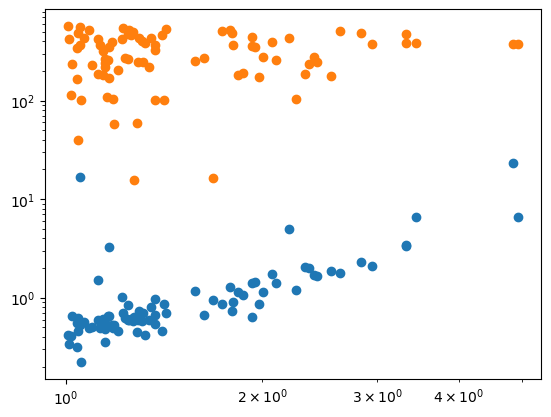

In [130]:
%run -i 'utils/functions.py'

fix = E(np.array(redshifts7))

plt.scatter(masses, clusters["Lx500"].values/fix)
plt.scatter(masses, lumins7/fix)
plt.xscale("log")
plt.yscale("log")
plt.show()

## (H) Temperature vs. mass

Beta: [0.42517531 1.29351023]
Beta Std Error: [0.02721944 0.06042082]
Beta Covariance: [[ 0.00037375 -0.00079766]
 [-0.00079766  0.0018416 ]]
Residual Variance: 1.9823383546995283
Inverse Condition #: 0.09320425574080203
Reason(s) for Halting:
  Sum of squares convergence
0.16700162516196806 0.15689360676158667


<Figure size 640x480 with 0 Axes>

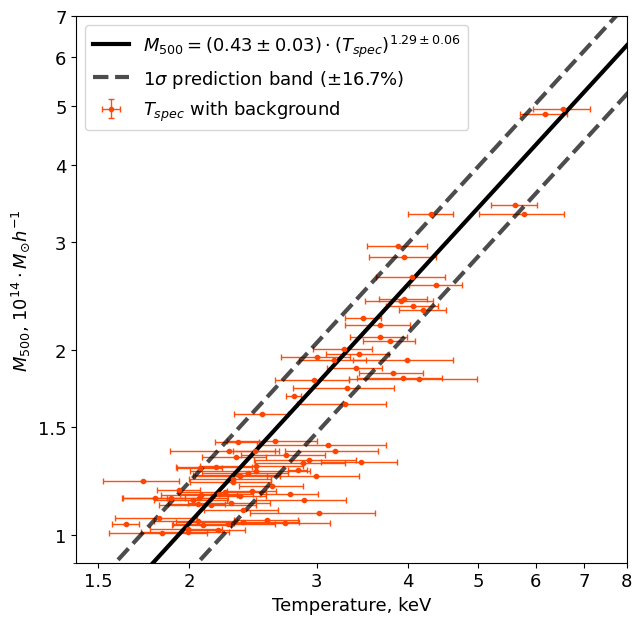

In [62]:
%run -i 'utils/functions.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before
T500S = list(clusters["T500"].values)
yyyy1 = [a[1] for a in temp_usr]
yyyy1_err = [a[2] for a in temp_usr]
#yyyy2 = [a[1] for a in temp_usr_with_bkg]
#yyyy2_err = [a[2] for a in temp_usr_with_bkg]

#print(clusters["z_true"].values)

lll = np.linspace(1, 9, 100) #*E(clusters["z_true"].values)

#draw_line(MASSES, np.zeros(len(MASSES)), T500S, np.array(T500S)*0,
#          clr = 'black', 
#          l4dots = '$T_{500}$ from simulations', 
#          l4legend = 'T_{{500}}',
#          argument='M_{{500}}', 
#          with_scatter=True,
#          with_intervals=False)

#draw_line(yyyy1, yyyy1_err, MASSES, np.zeros(len(MASSES)), 
#          clr = 'black', 
#          l4dots = '$T_{spec}$ without background', 
#          l4legend = 'M_{{500}}',
#          argument = 'T_{{spec}}', 
#          with_scatter=True,
#          with_intervals=True)

draw_line(yyyy1, yyyy1_err, MASSES, np.zeros(len(MASSES)),
          clr = 'orangered', 
          l4dots = '$T_{spec}$ with background', 
          l4legend = 'M_{{500}}',
          argument = '(T_{{spec}})', 
          with_scatter=True,
          with_intervals=True)

plt.ylabel("$M_{500}$, $10^{14} \cdot M_{\odot} h^{-1}$", fontsize=13)
plt.xlabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
plt.xlim(1.5, 8.9)

#plt.yticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([1, 1.5, 2, 3, 4, 5, 6, 7], [1, 1.5, 2, 3, 4, 5, 6, 7], size=13)
plt.xticks([1.5,2,3,4,5,6,7, 8], [1.5,2,3,4,5,6,7, 8], size=13)

plt.legend(loc=2, fontsize=13)

#plt.gca().add_patch(Rectangle((1.5, 0.5), 1, 0.47, linewidth=1, 
#                              edgecolor='w', facecolor='w', fill=True, zorder=2))
plt.xlim(1.4, 8)
plt.ylim(0.9, 7.0)

#plt.savefig('figures/T_vs_M_no_bkg.pdf', format='pdf')

plt.show()

Beta: [0.36458981 1.44880575]
Beta Std Error: [0.03342791 0.09119943]
Beta Covariance: [[ 0.00057804 -0.00153803]
 [-0.00153803  0.00430256]]
Residual Variance: 1.9331149875281444
Inverse Condition #: 0.06302475367572573
Reason(s) for Halting:
  Iteration limit reached
0.20523072084940897 0.20048947826616584


<Figure size 640x480 with 0 Axes>

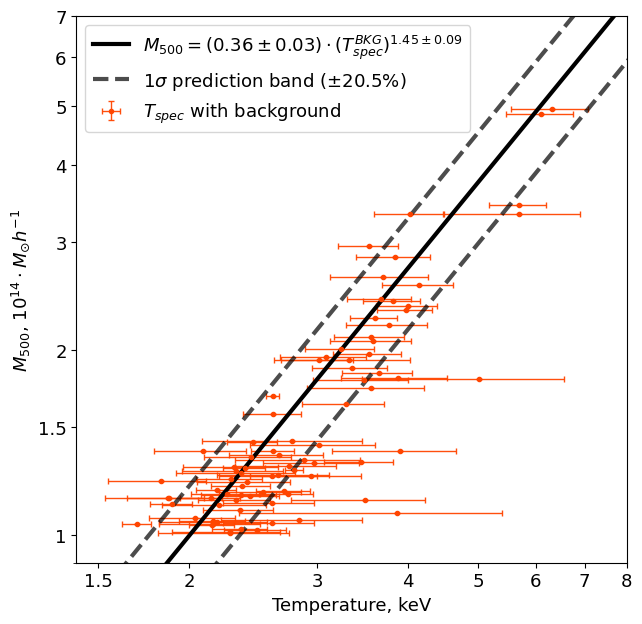

In [113]:
%run -i 'utils/functions.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before
T500S = list(clusters["T500"].values)
yyyy1 = [a[1] for a in temp_usr]
yyyy1_err = [a[2] for a in temp_usr]
yyyy2 = [a[1] for a in temp_usr_with_bkg]
yyyy2_err = [a[2] for a in temp_usr_with_bkg]

#print(clusters["z_true"].values)

lll = np.linspace(1, 9, 100) #*E(clusters["z_true"].values)

#draw_line(MASSES, np.zeros(len(MASSES)), T500S, np.array(T500S)*0,
#          clr = 'black', 
#          l4dots = '$T_{500}$ from simulations', 
#          l4legend = 'T_{{500}}',
#          argument='M_{{500}}', 
#          with_scatter=True,
#          with_intervals=False)

#draw_line(yyyy1, yyyy1_err, MASSES, np.zeros(len(MASSES)), 
#          clr = 'black', 
#          l4dots = '$T_{spec}$ without background', 
#          l4legend = 'M_{{500}}',
#          argument = 'T_{{spec}}', 
#          with_scatter=True,
#          with_intervals=True)

draw_line(yyyy2, yyyy2_err, MASSES, np.zeros(len(MASSES)),
          clr = 'black', 
          l4dots = '$T_{spec}$ with background', 
          l4legend = 'M_{{500}}',
          argument = '(T_{{spec}}^{{BKG}})', 
          with_scatter=True,
          with_intervals=True)

plt.ylabel("$M_{500}$, $10^{14} \cdot M_{\odot} h^{-1}$", fontsize=13)
plt.xlabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
plt.xlim(1.5, 8.9)

#plt.yticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([1, 1.5, 2, 3, 4, 5, 6, 7], [1, 1.5, 2, 3, 4, 5, 6, 7], size=13)
plt.xticks([1.5,2,3,4,5,6,7, 8], [1.5,2,3,4,5,6,7, 8], size=13)

plt.legend(loc=2, fontsize=13)

#plt.gca().add_patch(Rectangle((1.5, 0.5), 1, 0.47, linewidth=1, 
#                              edgecolor='w', facecolor='w', fill=True, zorder=2))
plt.xlim(1.4, 8)
plt.ylim(0.9, 7.0)

plt.savefig('figures/T_vs_M_with_bkg.pdf', format='pdf')

plt.show()

## (I) Average energy vs. mass

Beta: [0.53282533 9.79558624]
Beta Std Error: [0.02754141 0.41384267]
Beta Covariance: [[ 0.00043152 -0.00609595]
 [-0.00609595  0.09743232]]
Residual Variance: 1.7577920645811123
Inverse Condition #: 0.021791749839110548
Reason(s) for Halting:
  Iteration limit reached
0.17394850761490688 0.01856412744761418


<Figure size 640x480 with 0 Axes>

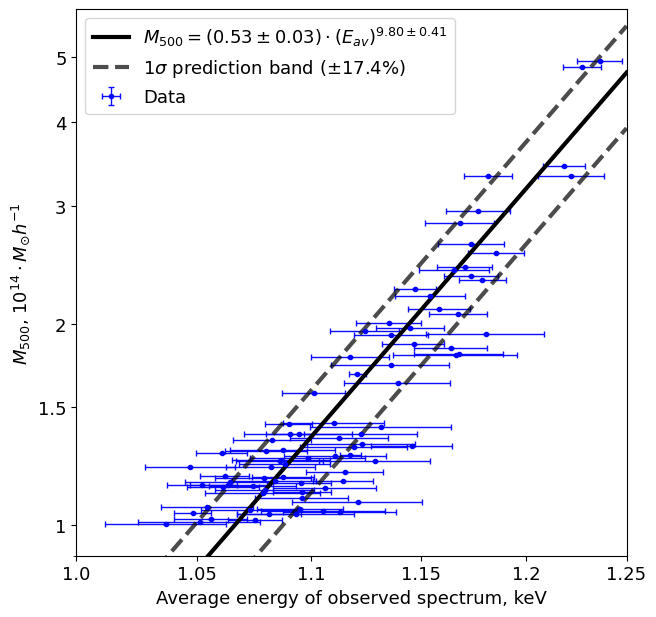

In [63]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before

yyyy1 = [a[0] for a in aven_usr]
yyyy1_err = [a[1] for a in aven_usr]
#yyyy2 = [a[0] for a in aven_usr_with_bkg]
#yyyy2_err = [a[1] for a in aven_usr_with_bkg]

#lll = np.linspace(min(MASSES), max(MASSES), 100)
lll = np.linspace(1, 1.25, 100)
    
draw_line(yyyy1, yyyy1_err, MASSES, np.zeros(len(MASSES)),
          clr = 'blue', #'dodgerblue', 
          l4dots = 'Data', 
          l4legend = 'M_{{500}}',
          argument = '(E_{{av}})',
          with_scatter=True)

#draw_line(yyyy2, yyyy2_err, MASSES, np.zeros(len(MASSES)), 
#          clr = 'orangered', 
#          l4dots = 'Data with background', 
#          l4legend = 'M_{{500}}',
#          argument = '(E_{{av}}^{{BKG}})',
#          with_scatter=True)    

plt.ylabel("$M_{500}$, $10^{14} \cdot M_{\odot} h^{-1}$", fontsize=13)
plt.xlabel("Average energy of observed spectrum, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

plt.ylim(0.9, 5.9)
plt.xlim(1, 1.25)

plt.yticks([1,1.5,2,3,4,5], [1,1.5,2,3,4,5], size=13)
plt.xticks([1.00, 1.05, 1.10, 1.15, 1.2, 1.25], [1.00, 1.05, 1.10, 1.15, 1.2, 1.25], size=13)

#plt.gca().add_patch(Rectangle((1, 0.6), 0.1, 0.36, linewidth=1, 
#                              edgecolor='w', facecolor='w', fill=True, zorder=2))

plt.legend(loc=2, fontsize=13)

#plt.savefig('figures/Eav_vs_M.pdf', format='pdf')

plt.show()

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

calculate_scatter(MASSES, yyyy1, plot=True)
calculate_scatter(MASSES, yyyy2, plot=True)

## (J) How many realisations are enough?

https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation

https://en.wikipedia.org/wiki/Bias_of_an_estimator

https://en.wikipedia.org/wiki/Bessel%27s_correction

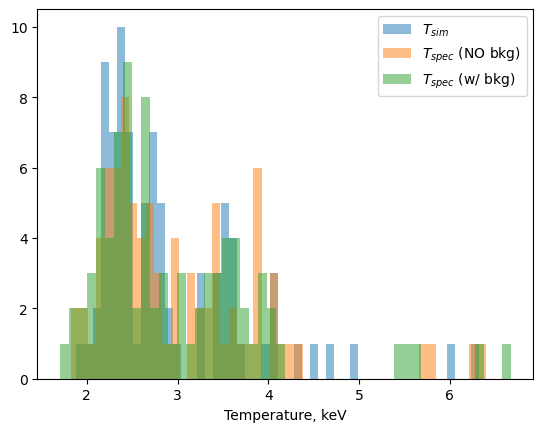

In [155]:
plt.hist([a[0] for a in temp_usr], bins=50, alpha=0.5, label="$T_{sim}$")
plt.hist([a[1] for a in temp_usr], bins=50, alpha=0.5, label="$T_{spec}$ (NO bkg)")
#plt.hist([a[0] for a in temp_usr_with_bkg], bins=20, alpha=0.5, label="$T_{sim}$")
plt.hist([a[1] for a in temp_usr_with_bkg], bins=50, alpha=0.5, label="$T_{spec}$ (w/ bkg)")
plt.xlabel("Temperature, keV")
plt.legend()
plt.show()

#### Lets check how the moments of our distribution depend on number of realisations:

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


<Figure size 640x480 with 0 Axes>

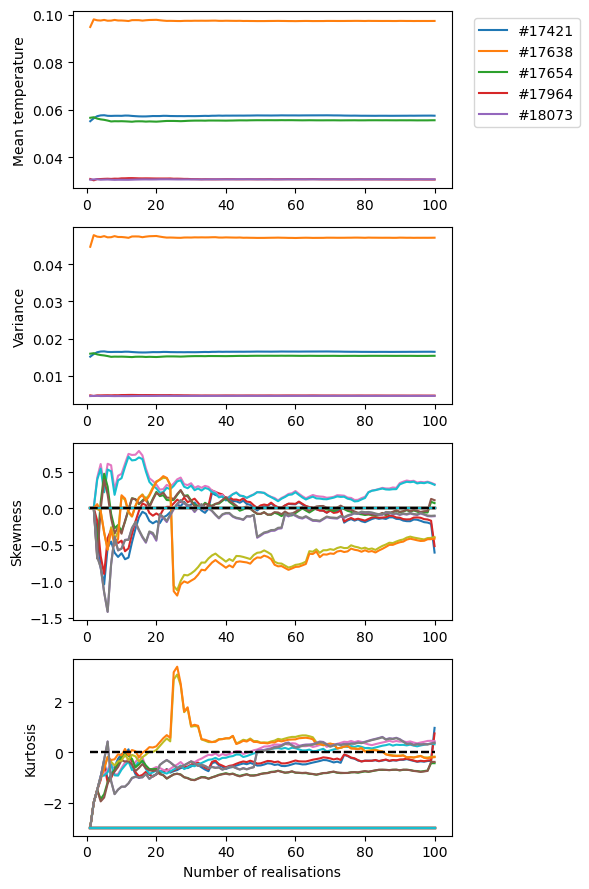

In [7]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,9))

N_realisations = 100

#CL_NUMBER = clusters.index[:][-1]

for CL_NUMBER in tqdm(clusters.index[-10:-5]):

    cl_red = clusters.loc[CL_NUMBER]["z_true"]
    cl_T500 = clusters.loc[CL_NUMBER]["T500"]
    cl_lum = clusters.loc[CL_NUMBER]["Lx500"]

    temps = []      # увеличивающийся со временем массив со всеми температурами
    
    means = [] # массив со средними для данного набора
    variances = []    # массив со стандартными отклонениями для каждого отдельного набора температур
    skewnesses = []
    kurtosises = []
    
    for i in tqdm(range(1, N_realisations+1), leave=False):
        
        Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius=1,
                                    Xplot=False, plot=False)

        temps.append(Ts[1])
        #print(temps)

        mean = np.mean(temps)
        variance = np.var(temps)
        skewness = stats.skew(temps)
        kurtosis = stats.kurtosis(temps, fisher=True)
        #print(np.sum(temps)/i)    

        # If True, Fisher’s definition is used (normal ==> 0.0).
        # If False, Pearson’s definition is used (normal ==> 3.0).

        means.append(mean)
        variances.append(variance)
        skewnesses.append(skewness)
        kurtosises.append(kurtosis) #True
        
        #print(i, end="")
        
    plt.subplot(4,1,1)
    plt.plot(np.linspace(1,i,i), means, label='#'+str(CL_NUMBER))
    #plt.xlabel("Number of realisations")
    plt.ylabel("Mean temperature")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    plt.subplot(4,1,2)
    plt.plot(np.linspace(1,i,i), variances, label='#'+str(CL_NUMBER))
    #plt.xlabel("Number of realisations")
    plt.ylabel("Variance")
    #plt.legend()
    
    plt.subplot(4,1,3)
    plt.plot(np.linspace(1,i,i), skewnesses, label='#'+str(CL_NUMBER))
    plt.plot(np.linspace(1,i,i), np.zeros(i), linestyle = '--', color='black') 
    #plt.xlabel("Number of realisations")
    plt.ylabel("Skewness")
    #plt.legend()
    
    plt.subplot(4,1,4)
    plt.plot(np.linspace(1,i,i), kurtosises, label='#'+str(CL_NUMBER))
    plt.plot(np.linspace(1,i,i), np.zeros(i), linestyle = '--', color='black')
    # [m**3+3*m*v for m, v in zip(means, variances)]
    plt.xlabel("Number of realisations")
    plt.ylabel("Kurtosis")
    #plt.legend()
    
    plt.subplots_adjust()
    plt.tight_layout()

    
plt.savefig("figures/check_if_norm_aven.pdf", format="pdf")
plt.show()

#### Pictures for histogram.gif

In [ ]:
%run -i 'utils/scripts.py'

N_realisations = 100

#CL_NUMBER = clusters.index[:][-1]

for CL_NUMBER in clusters.index[-5:-4]:

    cl_red = clusters.loc[CL_NUMBER]["z_true"]
    cl_T500 = clusters.loc[CL_NUMBER]["T500"]
    cl_lum = clusters.loc[CL_NUMBER]["Lx500"]

    temps = []      # увеличивающийся со временем массив со всеми температурами
    
    means = [] # массив со средними для данного набора
    variances = []    # массив со стандартными отклонениями для каждого отдельного набора температур
    skewnesses = []
    kurtosises = []
    
    Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False, draw_only=False, draw_and_save_atable_model=False)

    temps.append(Ts[0][0])

    for i in range(2, N_realisations+1):
        
        Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False, draw_only=False, draw_and_save_atable_model=False)

        temps.append(Ts[0][0])

        mean = np.mean(temps)
        stddev = np.std(temps)
        
        temps_norm = [(t-mean)/stddev for t in temps]
        
        plt.figure(figsize=(5,5))

        bars, bins = np.histogram(temps_norm)
        
        w = np.ones(len(temps_norm))#/len(temps_norm)
        
        plt.hist(temps_norm, weights = (1/np.sqrt(2*np.pi))*w/max(bars), color='#8c564b')
        
        xxxccc = np.linspace(-3,3,100)
        plt.plot(xxxccc, stats.norm.pdf(xxxccc), color='black', label="N(0,1)")
        
        plt.ylim(0, 0.44)
        
        plt.title("#"+str(CL_NUMBER)+": N="+str(i))
        plt.legend(loc="upper right")
        plt.xlabel("$(T_{spec} - T_{mean}) / \sigma$", fontsize=12)
    
        plt.savefig("../norm_dist/"+str(i)+".png", format="png")
        
        #plt.show()
        plt.clf()